# Instalar dependencias

In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.7 MB/s eta 0:00:00


# Cargar el dataset

In [2]:
import json
import torch
import os.path as osp
from torch_geometric.data import InMemoryDataset, download_url

class TournamentDataset(InMemoryDataset):

    TORUNAMENT_URL = 'https://drive.upm.es/s/mnsESjBucKUKsEg/download'

    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return ['tournament.pt']

    @property
    def processed_file_names(self):
        return ['tournament.pt']

    @property
    def num_classes(self):
        return 3

    @property
    def num_features(self):
        return 500

    def download(self):
        download_url(self.TORUNAMENT_URL, self.raw_dir, filename='tournament.pt')

    def process(self):
        data_list = [torch.load(osp.join(self.raw_dir, 'tournament.pt'))]

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        self.save(data_list, self.processed_paths[0])

    def create_test_json(self, model, file_path, device="cpu"):
        data = self[0]

        model = model.to(device)
        data = data.to(device)

        model.eval()
        out = model(data.x, data.edge_index)
        y_pred = out[data.test_mask].argmax(dim=1)
        nid = data.nid[data.test_mask]

        pred = {
            'nid': nid.detach().cpu().numpy().tolist(),
            'y': y_pred.detach().cpu().numpy().tolist()
        }

        with open(file_path, 'w') as f:
            json.dump(pred, f)


In [3]:
dataset = TournamentDataset("tournament")
data = dataset[0]

Processing...
<ipython-input-2-4ab60909218f>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_list = [torch.load(osp.join(self.raw_dir, 'tournament.pt'))]
Done!


# Definir el modelo

- Primera prueba: Baseline MLP
- Segunda prueba: Graph attention (16,32,64 neuronas) --> con 64 neuronas, 0.88
- Tercera prueba: Skip connection Concat (32,64 neuronas) --> con 64 neuronas y 270 epochs, 0.9062
- Cuarta prueba: Interpolate Skip connection (Adam, NAdam (empeoramiento))
- Quinta prueba (partiendo de la prueba 3), se añade una capa más skip concat --> empeora el mejor modelo
- Sexta prueba: se cambia el dropout (a 0.6 y a 0.4)

In [11]:
### MODELO 1: GRAPH ATTENTION
import torch
from torch_geometric.nn import MessagePassing, MLP
from torch_geometric.utils import add_self_loops, softmax

class CustomGATConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(CustomGATConv, self).__init__(aggr='sum')
        self.lin = torch.nn.Linear(in_channels, out_channels) # transformacion de paso de mensaje
        self.mlp_phi = MLP( # va a aprender el valor alpha
            in_channels=2*out_channels,
            out_channels=1, # salida 1, valor de agregacion
            hidden_channels=16,
            num_layers=1
        )

        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        self.mlp_phi.reset_parameters()

    def forward(self, x, edge_index):
        # Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Linearly transform node feature matrix.
        z = self.lin(x)

        # Start propagating messages.
        return self.propagate(edge_index, size=(z.size(0), z.size(0)), x=z)

    def message(self, edge_index_i, x_i, x_j, size_i):
        # Compute attention coefficients. x_i es el nodo sobre el que se hace la agregacion, x_j es el vecino
        x_ij = torch.cat([x_i, x_j], dim=1)
        alpha = self.mlp_phi(x_ij)
        alpha = softmax(alpha, edge_index_i, num_nodes=size_i) # edge_index_i aristas del nodo sobre el que se quiere calcular softmax de sus vecinos

        return alpha * x_j

    def update(self, aggr_out):
        # aggr_out has shape [N, out_channels]

        # Return new node embeddings.
        return aggr_out

import torch
import torch.nn.functional as F
# tambien disponible en GATConv
from torch_geometric.nn import GATConv, MLP

class GCN(torch.nn.Module):
    def __init__(self, node_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = CustomGATConv(node_features, hidden_channels)
        self.conv2 = CustomGATConv(hidden_channels, hidden_channels)
        self.cls = MLP(in_channels=hidden_channels, out_channels=num_classes, num_layers=2, hidden_channels=hidden_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.cls(x)
        return x

model = GCN(500, 64, 3) # 0.88


#### mejor modelo

In [87]:
### concat skip connections
import torch
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing

class SkipConcatConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(SkipConcatConv, self).__init__(aggr='sum')

        self.W_theta = Linear(in_channels + out_channels, out_channels)
        self.b_theta = Parameter(torch.Tensor(out_channels))

        self.W_phi = Linear(in_channels, out_channels)
        self.b_phi = Parameter(torch.Tensor(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        self.W_theta.reset_parameters()
        self.b_theta.data.zero_()
        self.W_phi.reset_parameters()
        self.b_phi.data.zero_()

    def forward(self, x, edge_index):
        return self.propagate(edge_index, x=x, central_node=x)

    def message(self, x_j):
        return self.W_phi(x_j) + self.b_phi

    def update(self, aggr_out, central_node):
        a = torch.concat([central_node, aggr_out], dim=1)
        return self.W_theta(a) + self.b_theta

import torch
import torch.nn.functional as F
# tambien disponible en GATConv
from torch_geometric.nn import MLP

class GCN(torch.nn.Module):
    def __init__(self, node_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = SkipConcatConv(node_features, hidden_channels)
        self.conv2 = SkipConcatConv(hidden_channels, hidden_channels)
        self.cls = MLP(in_channels=hidden_channels, out_channels=num_classes, num_layers=2, hidden_channels=hidden_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.cls(x)
        return x

model = GCN(500, 64, 3) # 0.90

#### otros modelos

In [33]:
### interpolate skip connection
import torch
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing

class InterpolateSkipConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(InterpolateSkipConv, self).__init__(aggr='sum')

        self.W_theta = Linear(in_channels, out_channels)
        self.b_theta = Parameter(torch.Tensor(out_channels))

        self.W_phi = Linear(in_channels, out_channels)
        self.b_phi = Parameter(torch.Tensor(out_channels))

        self.alpha = Parameter(torch.Tensor(1))

        self.reset_parameters()

    def reset_parameters(self):
        self.W_theta.reset_parameters()
        self.b_theta.data.zero_()
        self.W_phi.reset_parameters()
        self.b_phi.data.zero_()
        self.alpha.data.fill_(0.5)

    def forward(self, x, edge_index):
        return self.propagate(edge_index, x=x, central_node=x)

    def message(self, x_j):
        return self.W_phi(x_j) + self.b_phi

    def update(self, aggr_out, central_node):
        z_i = self.W_theta(central_node) + self.b_theta
        return self.alpha * z_i + (1 - self.alpha) * aggr_out

import torch
import torch.nn.functional as F
# tambien disponible en GATConv
from torch_geometric.nn import MLP

class GCN(torch.nn.Module):
    def __init__(self, node_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = InterpolateSkipConv(node_features, hidden_channels)
        self.conv2 = InterpolateSkipConv(hidden_channels, hidden_channels)
        self.cls = MLP(in_channels=hidden_channels, out_channels=num_classes, num_layers=2, hidden_channels=hidden_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.cls(x)
        return x

model = GCN(500,64,3)

In [62]:
### concat skip connections
import torch
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing

class SkipConcatConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(SkipConcatConv, self).__init__(aggr='sum')

        self.W_theta = Linear(in_channels + out_channels, out_channels)
        self.b_theta = Parameter(torch.Tensor(out_channels))

        self.W_phi = Linear(in_channels, out_channels)
        self.b_phi = Parameter(torch.Tensor(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        self.W_theta.reset_parameters()
        self.b_theta.data.zero_()
        self.W_phi.reset_parameters()
        self.b_phi.data.zero_()

    def forward(self, x, edge_index):
        return self.propagate(edge_index, x=x, central_node=x)

    def message(self, x_j):
        return self.W_phi(x_j) + self.b_phi

    def update(self, aggr_out, central_node):
        a = torch.concat([central_node, aggr_out], dim=1)
        return self.W_theta(a) + self.b_theta

import torch
import torch.nn.functional as F
# tambien disponible en GATConv
from torch_geometric.nn import MLP

class GCN(torch.nn.Module):
    def __init__(self, node_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = SkipConcatConv(node_features, hidden_channels)
        self.conv2 = SkipConcatConv(hidden_channels, hidden_channels)
        self.conv3 = SkipConcatConv(hidden_channels, hidden_channels)
        self.cls = MLP(in_channels=hidden_channels, out_channels=num_classes, num_layers=2, hidden_channels=hidden_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.cls(x)
        return x

model = GCN(500, 64, 3)

In [4]:
# from torch_geometric.nn import MLP

# model = MLP(
#     in_channels=dataset.num_node_features,
#     out_channels=dataset.num_classes,
#     num_layers=2,
#     hidden_channels=32
# )

In [67]:
### concat skip connections con mean
import torch
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing

class SkipConcatConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(SkipConcatConv, self).__init__(aggr='mean')

        self.W_theta = Linear(in_channels + out_channels, out_channels)
        self.b_theta = Parameter(torch.Tensor(out_channels))

        self.W_phi = Linear(in_channels, out_channels)
        self.b_phi = Parameter(torch.Tensor(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        self.W_theta.reset_parameters()
        self.b_theta.data.zero_()
        self.W_phi.reset_parameters()
        self.b_phi.data.zero_()

    def forward(self, x, edge_index):
        return self.propagate(edge_index, x=x, central_node=x)

    def message(self, x_j):
        return self.W_phi(x_j) + self.b_phi

    def update(self, aggr_out, central_node):
        a = torch.concat([central_node, aggr_out], dim=1)
        return self.W_theta(a) + self.b_theta

import torch
import torch.nn.functional as F
# tambien disponible en GATConv
from torch_geometric.nn import MLP

class GCN(torch.nn.Module):
    def __init__(self, node_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = SkipConcatConv(node_features, hidden_channels)
        self.conv2 = SkipConcatConv(hidden_channels, hidden_channels)
        self.cls = MLP(in_channels=hidden_channels, out_channels=num_classes, num_layers=2, hidden_channels=hidden_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.cls(x)
        return x

model = GCN(500, 64, 3) # 0.90

# Entrenar el modelo

In [76]:
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

optimizer = Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
optm_func = CrossEntropyLoss()

data = data.to(device)

model.train()
for epoch in range(270):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = optm_func(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss {loss.item()}")

Epoch 0: Loss 1.153319239616394
Epoch 10: Loss 0.8771823048591614
Epoch 20: Loss 0.6717701554298401
Epoch 30: Loss 0.5114012360572815
Epoch 40: Loss 0.4074685275554657
Epoch 50: Loss 0.3176323175430298
Epoch 60: Loss 0.2591296136379242
Epoch 70: Loss 0.21291786432266235
Epoch 80: Loss 0.2477327138185501
Epoch 90: Loss 0.2366335093975067
Epoch 100: Loss 0.19340026378631592
Epoch 110: Loss 0.15058842301368713
Epoch 120: Loss 0.1319863200187683
Epoch 130: Loss 0.11817160248756409
Epoch 140: Loss 0.43964654207229614
Epoch 150: Loss 0.3332468867301941
Epoch 160: Loss 0.3002515137195587
Epoch 170: Loss 0.27460795640945435
Epoch 180: Loss 0.3070397973060608
Epoch 190: Loss 0.2602943778038025
Epoch 200: Loss 0.23071227967739105
Epoch 210: Loss 0.2433076798915863
Epoch 220: Loss 0.19671863317489624
Epoch 230: Loss 0.1759236603975296
Epoch 240: Loss 0.15649887919425964
Epoch 250: Loss 0.15312793850898743
Epoch 260: Loss 0.12964777648448944


In [88]:
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

optimizer = Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
optm_func = CrossEntropyLoss()

data = data.to(device)

model.train()
for epoch in range(270):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = optm_func(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss {loss.item()}")

Epoch 0: Loss 1.1387802362442017
Epoch 10: Loss 0.7484097480773926
Epoch 20: Loss 0.44223257899284363
Epoch 30: Loss 0.33104637265205383
Epoch 40: Loss 0.26934000849723816
Epoch 50: Loss 0.21589510142803192
Epoch 60: Loss 0.1765541285276413
Epoch 70: Loss 0.15784142911434174
Epoch 80: Loss 0.1283763200044632
Epoch 90: Loss 0.11571115255355835
Epoch 100: Loss 0.1009870320558548
Epoch 110: Loss 0.10382680594921112
Epoch 120: Loss 0.12218768149614334
Epoch 130: Loss 0.10290553420782089
Epoch 140: Loss 0.08324898034334183
Epoch 150: Loss 0.06919018924236298
Epoch 160: Loss 0.05915418267250061
Epoch 170: Loss 0.05723487585783005
Epoch 180: Loss 0.05050764977931976
Epoch 190: Loss 0.05482975021004677
Epoch 200: Loss 0.05937863141298294
Epoch 210: Loss 0.05688099190592766
Epoch 220: Loss 0.04858970642089844
Epoch 230: Loss 0.046917498111724854
Epoch 240: Loss 0.05248316004872322
Epoch 250: Loss 0.04711388051509857
Epoch 260: Loss 0.04540685564279556


# entrenar con early stopping

In [63]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

optimizer = Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
optm_func = CrossEntropyLoss()

data = data.to(device)

best_loss = float('inf')  # Inicializamos la mejor pérdida con un valor muy alto
patience = 50  # Número de épocas que esperamos antes de detener el entrenamiento
counter = 0  # Contador para epochs sin mejora
best_model_state = None  # Aquí almacenaremos el mejor estado del modelo

model.train()
for epoch in range(301):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = optm_func(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    # Monitoreamos la pérdida mínima
    if loss.item() < best_loss:
        best_loss = loss.item()  # Actualizamos la mejor pérdida
        counter = 0  # Reiniciamos el contador
        best_model_state = model.state_dict()  # Guardamos el mejor estado del modelo
    else:
        counter += 1  # Incrementamos el contador

    # Detenemos si no hay mejora en la pérdida por 'patience' épocas
    if counter >= patience:
        print(f"Early stopping at epoch {epoch}. Best loss: {best_loss:.4f}")
        break

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss {loss.item():.4f}")

# Al finalizar, cargamos el mejor modelo encontrado
model.load_state_dict(best_model_state)
print("Entrenamiento terminado. Modelo cargado con la mejor pérdida registrada.")

Epoch 0: Loss 1.3044
Epoch 10: Loss 0.9527
Epoch 20: Loss 0.9646
Epoch 30: Loss 0.9140
Epoch 40: Loss 0.8333
Epoch 50: Loss 0.7917
Epoch 60: Loss 0.7730
Epoch 70: Loss 0.7245
Epoch 80: Loss 0.6312
Epoch 90: Loss 0.5445
Epoch 100: Loss 0.4967
Epoch 110: Loss 0.3646
Epoch 120: Loss 0.2905
Epoch 130: Loss 0.2857
Epoch 140: Loss 0.4027
Epoch 150: Loss 0.2876
Epoch 160: Loss 0.2583
Epoch 170: Loss 0.2318
Epoch 180: Loss 0.2236
Epoch 190: Loss 0.1973
Epoch 200: Loss 0.2215
Epoch 210: Loss 0.8130
Epoch 220: Loss 0.6112
Epoch 230: Loss 0.4079
Epoch 240: Loss 0.3603
Early stopping at epoch 245. Best loss: 0.1853
Entrenamiento terminado. Modelo cargado con la mejor pérdida registrada.


# Validación

F1 score: 0.8890140845070422


<Axes: >

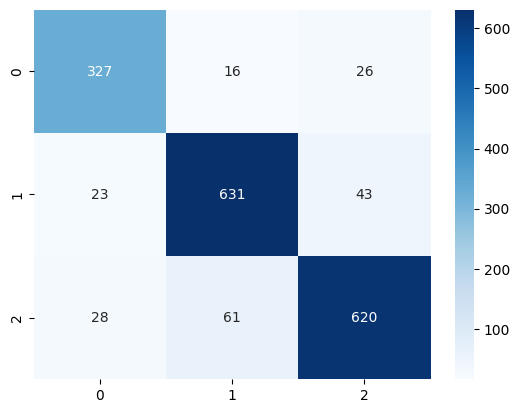

In [89]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

model.eval()
out = model(data.x, data.edge_index)
y_pred = out.argmax(dim=1)[data.val_mask].detach().cpu()
y = data.y.argmax(dim=1)[data.val_mask].detach().cpu()

print(f"F1 score: {f1_score(y, y_pred, average='micro')}")
sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='g', cmap='Blues')

# Generar solución para el torneo

In [90]:
dataset.create_test_json(model, 'pred_labels.json', device=device)